# Plasmids MILP experiment 3

## Description

The following describes the results of the experiment with the second version of the iterative Plasmids assembly MILP. Similar to experiment 2, the formulation has new constraints that try to determine a path. In other words, the obtained plasmid should have a single component which is path. However, these constraints are also satisfied by graphs with multiple component containing exactly 1 path and the rest as cycles. Hence, the formulation is not perfect. Second, we determine the plasmids iteratively, one at a time. The assembly graph is then updated since some of the read depth has been used for some contigs. The MILP is then run again using the updaed graph till a stopping condition has been reached. For each run, we record the average and maximum precision, recall and F1 score.

In addition to these constraints, we also separate questionable plasmids away from putative plasmids. The conditions under which a plasmid is classified as putative are as follows:
1. min_gene_density[plasmid] $>=$ 0.3
2. min_gene_density[seed_contig] $>=$ 1.5$*$min_gene_density[plasmid] $=$ 0.45
3. 1500 $<=$ min_length[plasmid] $<=$ 1750000

The putative and questionable plasmids are then stored in different files. The results shown below are for the putative plasmids. 

In [23]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.switch_backend('agg')
%matplotlib inline

In [2]:
output_dir = '../output'
greedy_dir = '../../../../Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2'

In [3]:
def update_dict(line, stat_dict, file, folder_loc):
    stat = line.split(" ")[-1]
    stat_dict[file.split('/')[folder_loc]].append(float(stat))
    return stat_dict

In [4]:
def compute_mean(mean, k, precs, recs, f1s):
    mean[k] = {}
    mean[k]['precision'] = sum(precs[k])/len(precs[k])
    mean[k]['recall'] = sum(recs[k])/len(recs[k])
    mean[k]['f1_score'] = sum(f1s[k])/len(f1s[k])
    return mean

In [5]:
def compute_max(best, k, precs, recs, f1s):
    best[k] = {}
    best[k]['precision'] = max(precs[k])
    best[k]['recall'] = max(recs[k])
    best[k]['f1_score'] = max(f1s[k])
    return best

## Statistics for different samples

In this part, we use the same $\alpha$ ratios as in the previous experiment (which performed better than others). The ratios chosen for this part are 1.1.0, 1.1.1, 1.2.1 and 1.5.1. For each ratio, the MILP was run with nplasmids  $=1$. In other words, although we remove one plasmid at a time in this experiment, the MILP has provisions to remove  $k>$1  plasmids in one iteration, provided convergence is reached. The main motivation behind the iterative plasmid generation approach is to help in reaching convergence by reducing the number of variables.

A set of 10 ids was chosen to test the general performance of the MILP. These were the same ids as in the previous experiments.

The results for the 10 chosen sample ids have been compared with the results of the greedy heuristic by Robert. The results of the greedy heuristic can be found at '/Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2'.

In [20]:
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(output_dir) for f in filenames if "eval.csv" in f]
precs, recs, f1s = defaultdict(list), defaultdict(list), defaultdict(list)
prec_ratio, rec_ratio, f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

for file in files:
    if 'sample' in file.split('/')[2]:
        sample_id = file.split('/')[2].split('_')[1]
        ratio = file.split('/')[3]
        with open(file, 'r') as f:
            for line in f:
                if "precision" in line:
                    precs = update_dict(line, precs, file, 2)
                    prec_ratio = update_dict(line, prec_ratio, file, 3)
                if "recall" in line:
                    recs = update_dict(line, recs, file, 2)
                    rec_ratio = update_dict(line, rec_ratio, file, 3)
                if "f1" in line:
                    f1s = update_dict(line, f1s, file, 2)
                    f1_ratio = update_dict(line, f1_ratio, file, 3)                  

In [7]:
mean, best = {}, {}
mean_scores, best_scores = [], [] 
for sample_id in precs:
    mean[sample_id] = {}
    mean[sample_id]['precision'] = sum(precs[sample_id])/len(precs[sample_id])
    mean[sample_id]['recall'] = sum(recs[sample_id])/len(recs[sample_id])
    mean[sample_id]['f1_score'] = sum(f1s[sample_id])/len(f1s[sample_id])
    mean_scores.append([sample_id, mean[sample_id]['precision'], mean[sample_id]['recall'], mean[sample_id]['f1_score']])

    best[sample_id] = {}
    best[sample_id]['precision'] = max(precs[sample_id])
    best[sample_id]['recall'] = max(recs[sample_id])
    best[sample_id]['f1_score'] = max(f1s[sample_id])  
    best_scores.append([sample_id, best[sample_id]['precision'], best[sample_id]['recall'], best[sample_id]['f1_score']])

mean_scores = pd.DataFrame(mean_scores)
mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

best_scores = pd.DataFrame(best_scores)
best_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

In the following tables, the precision, recall and F1 score have been recorded. For each sample id, the MILP was run for all four ratios mentioned above and the average values over the four ratios has been stored in Table 1. Further the best values obtained over the four has been stored in Table 2. Table 3 shows the average precision, recall and F1 score for the greedy strategy.

#### Table 1: Average scores for each sample

In [8]:
mean_scores

,Sample,Precision,Recall,F1 score
0,sample_56,0.641347,0.845346,0.721386
1,sample_125,0.820723,0.830218,0.814052
2,sample_66,0.911321,0.927429,0.919287
3,sample_103,0.560434,0.860687,0.678832
4,sample_39,0.618664,0.718040,0.664061
5,sample_109,0.787221,0.685106,0.730738
6,sample_117,0.703003,0.573246,0.631375
7,sample_116,0.984959,0.324472,0.488135
8,sample_11,0.341674,0.736025,0.462638
9,sample_23,0.006270,0.037899,0.010189


#### Table 2: Maximum scores for each sample

In [9]:
best_scores

,Sample,Precision,Recall,F1 score
0,sample_56,0.743176,0.931326,0.734479
1,sample_125,0.986308,0.999986,0.990525
2,sample_66,0.973091,0.976130,0.974608
3,sample_103,0.580258,0.887455,0.701708
4,sample_39,0.648860,0.806992,0.719338
5,sample_109,0.819145,0.795114,0.806951
6,sample_117,0.720002,0.585002,0.642790
7,sample_116,0.988417,0.324472,0.488562
8,sample_11,0.494054,0.930881,0.641092
9,sample_23,0.014582,0.041593,0.021594


In [10]:
ids = mean_scores['Sample'].values.tolist()
greedy_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(greedy_dir) for f in filenames if "greedy_mean.csv" in f]
greedy_precs, greedy_recs, greedy_f1s = defaultdict(list), defaultdict(list), defaultdict(list)

count = {}
for file in greedy_files:
    if file.split('/')[9] in ids:
        with open(file, 'r') as f:
            rl, pl, fl = [], [], []
            for line in f:
                if "score_ref_coverage" in line:
                    rl.append(line)
                if "score_pred_coverage" in line:
                    pl.append(line)
                if "overall_score" in line:
                    fl.append(line)       
            greedy_recs = update_dict(rl[0], greedy_recs, file, 9)
            greedy_precs = update_dict(pl[0], greedy_precs, file, 9)
            greedy_f1s = update_dict(fl[0], greedy_f1s, file, 9)                    

In [11]:
greedy_mean = {}
greedy_mean_scores = [] 
for sample_id in greedy_precs:
    greedy_mean[sample_id] = {}
    greedy_mean[sample_id]['precision'] = sum(greedy_precs[sample_id])/len(greedy_precs[sample_id])
    greedy_mean[sample_id]['recall'] = sum(greedy_recs[sample_id])/len(greedy_recs[sample_id])
    greedy_mean[sample_id]['f1_score'] = sum(greedy_f1s[sample_id])/len(greedy_f1s[sample_id])
    greedy_mean_scores.append([sample_id, greedy_mean[sample_id]['precision'], greedy_mean[sample_id]['recall'], greedy_mean[sample_id]['f1_score']])

greedy_mean_scores = pd.DataFrame(greedy_mean_scores)
greedy_mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 3: Mean scores using greedy heuristic

In [12]:
greedy_mean_scores

,Sample,Precision,Recall,F1 score
0,sample_56,1.000000,0.976956,0.988478
1,sample_125,1.000000,0.996320,0.998160
2,sample_66,1.000000,1.000000,1.000000
3,sample_103,0.580096,0.900643,0.740370
4,sample_39,0.908497,0.915360,0.911929
5,sample_109,1.000000,0.983308,0.991655
6,sample_117,0.999994,0.989847,0.994921
7,sample_116,1.000000,0.324472,0.662236
8,sample_11,0.862581,0.954005,0.908293
9,sample_23,0.609916,1.000000,0.804958


In [13]:
N = 10
ind = np.arange(N)
width = 0.27

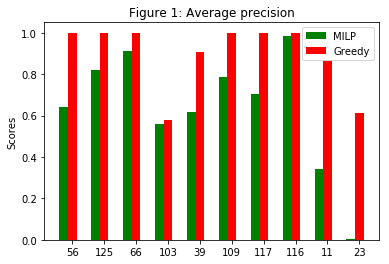

In [14]:
fig = plt.figure()
axp = fig.add_subplot(111)

ids = mean_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]

pvals = mean_scores['Precision'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
gpvals = greedy_mean_scores['Precision'].values.tolist()
rects2 = axp.bar(ind+width, gpvals, width, color='r')

axp.set_title('Figure 1: Average precision')
axp.set_ylabel('Scores')
axp.set_xticks(ind+width)
axp.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8], ids[9]) )
axp.legend( (rects1[0], rects2[0]), ('MILP', 'Greedy') )

plt.show()

From Figures 1,2 and 3, it is clear that the greedy strategy consistently outperforms the MILP strategy. The main difference between the two methods is noticed in the average precisions. However, the results are better than the previous versions of the MILP strategy. From the last version, the acceptance criteria was improved (through segregation into putative and questionable plasmids). The next step would be to add the path constraints through iterative removal of circular segments. In order to weed out plasmids with very low mean read depths, a read depth thresold can be added as part of the criteria for putative plasmids.

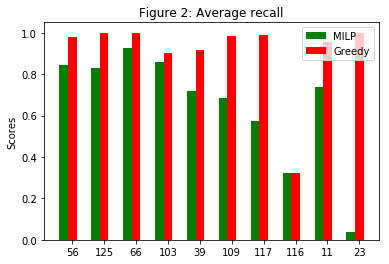

In [15]:
N = 10
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axr = fig.add_subplot(111)

rvals = mean_scores['Recall'].values.tolist()
rects3 = axr.bar(ind, rvals, width, color='g')
grvals = greedy_mean_scores['Recall'].values.tolist()
rects4 = axr.bar(ind+width, grvals, width, color='r')

axr.set_title('Figure 2: Average recall')
axr.set_ylabel('Scores')
axr.set_xticks(ind+width)
axr.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8], ids[9]) )
axr.legend( (rects3[0], rects4[0]), ('MILP', 'Greedy') )

plt.show()

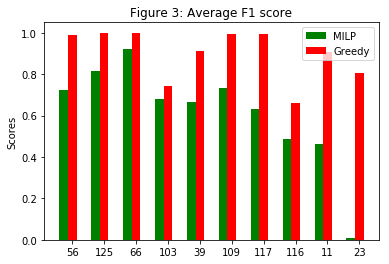

In [16]:
N = 10
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axf = fig.add_subplot(111)


fvals = mean_scores['F1 score'].values.tolist()
rects5 = axf.bar(ind, fvals, width, color='g')
gfvals = greedy_mean_scores['F1 score'].values.tolist()
rects6 = axf.bar(ind+width, gfvals, width, color='r')

axf.set_title('Figure 3: Average F1 score')
axf.set_ylabel('Scores')
axf.set_xticks(ind+width)
axf.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8], ids[9]) )
axf.legend( (rects5[0], rects6[0]), ('MILP', 'Greedy') )

plt.show()

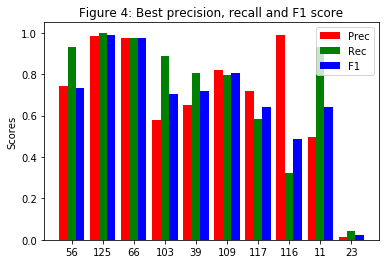

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

pvals = best_scores['Precision'].values.tolist()
rects1 = ax.bar(ind, pvals, width, color='r')
rvals = best_scores['Recall'].values.tolist()
rects2 = ax.bar(ind+width, rvals, width, color='g')
fvals = best_scores['F1 score'].values.tolist()
rects3 = ax.bar(ind+width*2, fvals, width, color='b')
ids = best_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]
ax.set_title('Figure 4: Best precision, recall and F1 score')
ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8], ids[9]) )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Prec', 'Rec', 'F1') )
plt.show()
plt.savefig(os.path.join(output_dir,'best_scores_MILP_exp-1.pdf'), format = 'pdf', dpi = 1200, bbox_inches = 'tight')

## Identifying the best ratio of coefficients in the objective function

In [21]:
ratio_mean = {}
ratio_mean_scores = [] 
for ratio in prec_ratio:
    ratio_mean[ratio] = {}
    ratio_mean[ratio]['precision'] = sum(prec_ratio[ratio])/len(prec_ratio[ratio])
    ratio_mean[ratio]['recall'] = sum(rec_ratio[ratio])/len(rec_ratio[ratio])
    ratio_mean[ratio]['f1_score'] = sum(f1_ratio[ratio])/len(f1_ratio[ratio])
    ratio_mean_scores.append([ratio, ratio_mean[ratio]['precision'], ratio_mean[ratio]['recall'], ratio_mean[ratio]['f1_score']])

ratio_mean_scores = pd.DataFrame(ratio_mean_scores)
ratio_mean_scores.rename(columns = {0: 'Ratio', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 4: Precision, recall and F1 score for various ratios

In [22]:
ratio_mean_scores

,Ratio,Precision,Recall,F1 score
0,1.1.0,0.635821,0.626794,0.604377
1,1.2.1,0.606279,0.609985,0.566058
2,1.1.1,0.653550,0.669891,0.627622
3,1.5.1,0.654595,0.708719,0.650221


From Table 4, we can see that ratio $\alpha_1:\alpha_2:\alpha_3 = 1:5:1$ marginally outperforms the ratio $\alpha_1:\alpha_2:\alpha_3 = 1:1:1$. This suggests a possibility that more weightage to $\alpha_2$ (weighted average of gene coverage of a plasmid) may improve the results. Since the other two ratios do not perform well, they could be replaced with ratios giving higher weightage to $\alpha_2$ in order to see if the performance consistently improves with $\alpha_2$.